# CC5215: Privacidad de Datos
## Laboratorio 4

Integrantes:

- Diego Espinoza

In [57]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')
adult = adult.dropna()

In [58]:
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Question 1 (10 points)

As you can imagine, the column Capital Gain does not have an obvious upper bound. Therefore, in order to compute a differentially private sum of that column, we need to clip the column.

Complete the function `find_sensitivity_clipping_cgain` that plots the sum of 'Capital Gain' for different clipping parameters. Your function should not use more of a privacy budget than `epsilon`.

_Hint_: Explore different cliping parameters using a step of `10000` and a reasonable number of iterations.

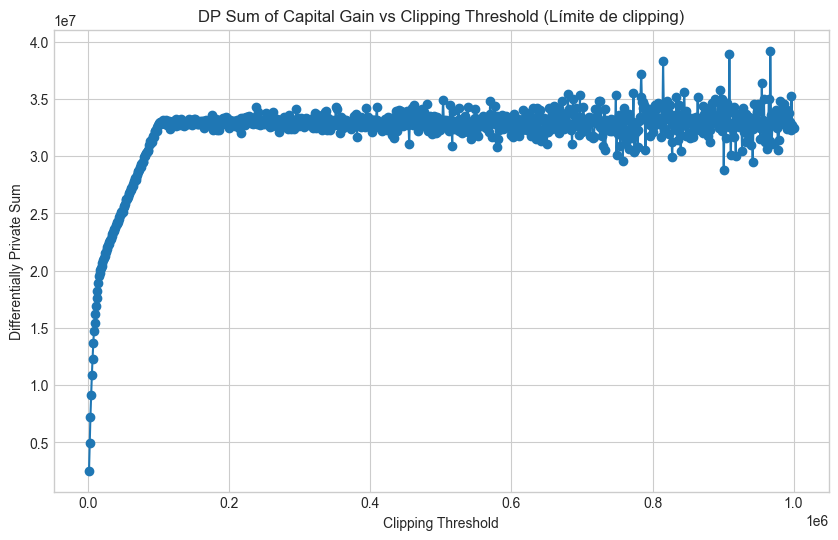

In [59]:
def find_sensitivity_clipping_cgain(epsilon):
    """Esta funcion lo que hace es probar diferentes "generalizaciones"
    de la columna Capital Gain del dataframe adult para ver cómo cambia 
    el valor de la consulta diferencialmente privada de la suma. 

    Args:
        epsilon (_type_): este es el presupuesto de privacidad
    """
    #ahora defino un arreglo que contiene diez mil valores diferentes.
    valores_de_clipping = np.arange(1000, 1000001, 1000)
    sumas_dif_privadas = []

    for clip in valores_de_clipping:
        #aplicamos el df_clippeado
        df_clippeado = np.clip(adult['Capital Gain'], 0, clip)

        #evidentemente, si hacemos clip con 1000, por ejemplo, la cantidad de datos puede
        #cambiar a lo más 1000, por lo que la sensibilidad viene a ser igual al valor
        #del clip.
        sensibilidad = clip

        #Ahora aplicamos el mecanismo de Laplace para agregar ruido a la suma de la columna.
        noise = np.random.laplace(loc=0.0, scale=sensibilidad/epsilon)
        suma_dif_privada = df_clippeado.sum() + noise

        #vamos guardando las sumas diferencialmente_privadas.
        sumas_dif_privadas.append(suma_dif_privada)

    plt.figure(figsize=(10, 6))
    plt.plot(valores_de_clipping, sumas_dif_privadas, marker='o')
    plt.title('DP Sum of Capital Gain vs Clipping Threshold (Límite de clipping)')
    plt.xlabel('Clipping Threshold')
    plt.ylabel('Differentially Private Sum')
    plt.grid(True)
    plt.show()

CLIPPING_EPSILON = 1.0

find_sensitivity_clipping_cgain(CLIPPING_EPSILON)

In [60]:
# Define this variable for the next question

CAPGAIN_UPPER_BOUND = None

### Question 2 (10 points)

- What is a reasonable clipping parameter? and why?
- What was the privacy budget (`epsilon`) for each iteration?


- ANSWER 1: Como sabemos de antemano (no de este dataset en específico), la distribución de los sueldos de las personas suele ser con una cola muy larga hacia la derecha, es decir, con un skewness tal que se diferencia de una distribución simétrica. Esto implica que habrán valores muy alejados de la moda, en particular, que la media estará alejada de la mediana, y por consecuencia es necesario tomar valores de clipping mas o menos altos (como en este caso probablemente hablamos de dolares, tiene sentido pensar que 100 mil dolares es mucho más que la mediana de los datos, mediana que representa el sueldo de la mayoría de la clase "media"). Por otro lado, si hacemos clipping con valores muy bajos, corremos el riesgo de perder mucha utilidad puesto que quizas la mayoria de las personas son de bajos ingresos. Por último, podemos decir que el 100 mil es bueno porque es el balance entre intermedia sensibilidad (un clipping intermedio) y una suma intermedia (es decir, el ruido del mecanismo de Laplace no afecta mucho como para perder mucha utilidad). Como podemos ver por otro lado, justo en 100 mil el valor de la suma se estabiliza, por lo que hacer clipping con valores se vuelve innecesario porque se quita utilidad.

- ANSWER 2: El epsilon para cada iteración fue el mismo (en este caso de 0.1) porque de otra manera no se podría saber del gráfico si la diferencia de sumas viene dado por el parámetro epsilon (que por ejemplo vendría dado por el teorema de composicion) o bien por el parámetro sensibilidad (que viene dado mas bien por el valor del clip).


### Question 3 (10 points)

Complete the definition of `dp_sum_capgain` below, using the clipping parameter you previously found. Your definition should compute a differentially private sum of the "Capital Gain" column of the `adult` dataset, and have a total privacy cost of `epsilon`.

_Hint_: Remember that you already used some of the privacy budget for finding the clipping parameter.

In [61]:
def dp_sum_capgain(epsilon):
    """Resumen

    Args:
        epsilon (float): este parametro es el presupuesto
        total de privacidad

    Returns:
        suma_con_ruido (float): suma con ruido de Laplace
        luego de aplicar clipping con el valor encontrado en la parte anterior 
    """
    valor_clip = 100000
    epsilon_cota = CLIPPING_EPSILON
    #pero como ya usamos una parte del presupuesto de privacidad para 
    #encontrar el valor del clipping óptimo, entonces tenemos menos
    #presupuesto, porque El epsilon_suma = epsilon_max - epsilon_cota
    epsilon_suma = epsilon - epsilon_cota

    ganancia_de_capital_clippeada = adult["Capital Gain"].clip(upper=valor_clip)

    suma_verdadera = ganancia_de_capital_clippeada.sum()

    sensibilidad = valor_clip
    ruido = np.random.laplace(loc=0.0, scale = sensibilidad / epsilon_suma)

    return suma_verdadera + ruido

dp_sum_capgain(2.0)

32966881.04877428

In [62]:
# TEST CASES for question 3

real_sum = adult['Capital Gain'].sum()
r1 = np.mean([pct_error(real_sum, dp_sum_capgain(2.0)) for _ in range(100)])
r2 = np.mean([pct_error(real_sum, dp_sum_capgain(10.0)) for _ in range(100)])
r3 = np.mean([pct_error(real_sum, dp_sum_capgain(40.0)) for _ in range(100)])

print("Average errors:", r1, r2, r3)

assert r1 > 0
assert r2 > 0
assert r3 > 0
assert r1 < 0.5
assert r2 < 0.05
assert r3 < 0.01

Average errors: 0.31558932944873197 0.03619344126298674 0.007791753952982769


### Question 4 (10 points)

In 2-5 sentences each, answer the following:

- What was the sensitivity of the query you used in `dp_sum_capgain`, and how is it bounded?
- Argue that your definition of `dp_sum_capgain` has a total privacy cost of `epsilon`
- Is it necessary to do the sum again after computing the `CAPGAIN_UPPER_BOUND`? Can we do better?

- ANSWER 1: La sensibilidad que usé en la consulta dp_sum_capgain fue igual al valor del clip, y esta no cambia porque en esencia es igual al valor del clipping que encontré en la primera parte. Además, incluso si agregáramos un individuo de altos ingresos a la base de datos, su sueldo o ingresos estarían limitados por el límite superior, y por lo tanto la sensibilidad seguiría siendo igual al valor del clipping, porque el valor de la suma podría cambiar a lo sumo en ese mismo valor. 

- ANSWER 2: Dado que la operación que consiste en encontrar el valor del clip tiene una privacidad de "epsilon_cota" y dado que la privacidad de la funcion dp_sum_capgain tiene una privacidad de "epsilon - epsilon_cota", se deduce por el teorema de composición que la privacidad total es igual a "epsilon cota" + "epsilon - epsilon_cota" = "epsilon". Es decir, por la forma en que está definida la función es la razón por la que se cumple privacidad "epsilon".

- ANSWER 3: Es necesario hacer el cálculo de la suma porque el cálculo del valor del clipping por sí mismo no nos dice nada de la suma en sí. Sin embargo, podemos con información auxiliar evitar el uso de parte de nuestro presupuesto de privacidad en el cálculo del límite superior del clipping, y por lo tanto podríamos dedicar todo el presupuesto de privacidad a la suma de la consulta de arriba. Esto se puede hacer por ejemplo, estimando dicho parámetro en conocimiento a priori o bien en información o estadísticas públicas (es decir, que pertenecen a bases de datos públicas). 

### Question 5 (10 points)

Complete the definition of `dp_avg_capgain` below. Your definition should compute a differentially private average (mean) of the "Capital Gain" column of the adult dataset, and have a **total privacy cost of epsilon**.

_Hint_: Use 10% of the privacy budget for computing the count, and the rest for the sum

In [63]:
def dp_avg_capgain(epsilon):
    """Resumen: Esta función aplica mecanismo de Laplace con  diferentes 
    sensibilidades y epsilon para poder cumplir con el presupuesto de priva
    cidad y tambien con la definición de sensibilidad de cada operación. 

    Args:
        epsilon (float): este es el presupuesto total, que se dividirá
        entre el epsilon del conteo y el epsilon de la suma, 10 y 90% 
        respectivamente.

    Returns:
        promedio_dif_privado (float):
        este promedio se calcula como la división de dos cosas ruidosas:
        la suma y el conteo.
    """
    epsilon_conteo = 0.1*epsilon
    epsilon_suma = epsilon - epsilon_conteo
    CLIP_VALUE = 100000
    
    adult_clipped = adult["Capital Gain"].clip(upper=CLIP_VALUE)


    conteo = len(adult_clipped)
    conteo_ruidoso = conteo + np.random.laplace(loc=0.0, scale=1.0 / epsilon_conteo)

    suma_real = adult_clipped.sum()
    suma_ruidosa = suma_real + np.random.laplace(loc=0.0, scale=CLIP_VALUE / epsilon_suma)

    promedio_dif_privado = suma_ruidosa / conteo_ruidoso

    return promedio_dif_privado

dp_avg_capgain(2.0)

1087.3557713540793

In [64]:
# TEST CASE for question 5

real_avg = adult['Capital Gain'].mean()
r1 = np.mean([pct_error(real_avg, dp_avg_capgain(2.0)) for _ in range(100)])
r2 = np.mean([pct_error(real_avg, dp_avg_capgain(10.0)) for _ in range(100)])
r3 = np.mean([pct_error(real_avg, dp_avg_capgain(40.0)) for _ in range(100)])

print("Average errors:", r1, r2, r3)

assert r1 > 0
assert r2 > 0
assert r3 > 0
assert r1 < 0.5
assert r2 < 0.05
assert r3 < 0.01

Average errors: 0.1707453254111995 0.035010723216904543 0.009598972496586014


### Question 6 (10 points)

In 2-5 sentences each, answer the following:

- Argue that your definition of `dp_avg_capgain` has a total privacy cost of `epsilon`
- For sums and averages, which seems to be more important for accuracy - the value of the clipping parameter $b$ or the scale of the noise added? Why?
- Do you think the answer to the previous point will be true for every dataset? Why or why not?

- ANSWER 1: De la misma manera que en la parte anterior, usando el hint de la pregunta, definí el dp_avg_capgain como usando un 10% de la privacidad para el cálculo de la cantidad de filas de la columna, y el otro 90% para el cálculo de la suma. Por lo que epsilon_promedio = 0.1 * epsilon + 0.9 * epsilon = epsilon, por lo que la definición de la función cumple con un costo total de privacidad de "epsilon". Además, se suman los epsilon porque están trabajando sobre la misma base de datos (aplicamos composición secuencial, y por ende suma de epsilon's). 

- ANSWER 2: El parámetro b de clipping es proporcional a la sensibilidad de la consulta de la suma, pero no para el del conteo total. por otro lado, la que tiene mayor epsilon es la suma (por ende menor ruido proporcionalmente) que la del conteo. Por lo tanto, un b más grande reduce el sesgo (menos clipping) pero incrementa el ruido. En general, el que tiene más importancia para la precisión es el valor de B porque incrementa el ruido. 

- ANSWER 3: En datasets pequeños cualquier cantidad de ruido es muy ruidosa, por lo que da lo mismo la comparación entre ambos parámetros (aquí lo que importa es elegir un epsilon pequeño que nos permita disminuir el ruido). En datasets de tamaño mediano, la escala del ruido puede importar más y en los datasets con colas largas es importante o más crucial el clipping. Sin embargo, en cuanto a los que son intermedios o que son uniformemente distribuidos, hacer un clipping no ayuda nada porque no hay muchos outliers ni colas asimétricas necesariamente. Por lo tanto, depende del dataset. 

### Question 7 (10 points)

Write a function `dp_age_hist` that plots a histogram for the column Age where the count is performed in a differentially private manner. The histogram should show 10 bins.

_Hint 1_: Do not use the function `.hist()` directly. Instead, compute the count for each bin, make it private, and the use `.plot(kind='bar')`

_Hint 2_: You can use the parameter `bins=[n1, ..., n]` of the method `value_counts` to count the values of a column within bins of size 10, from 0 to 150

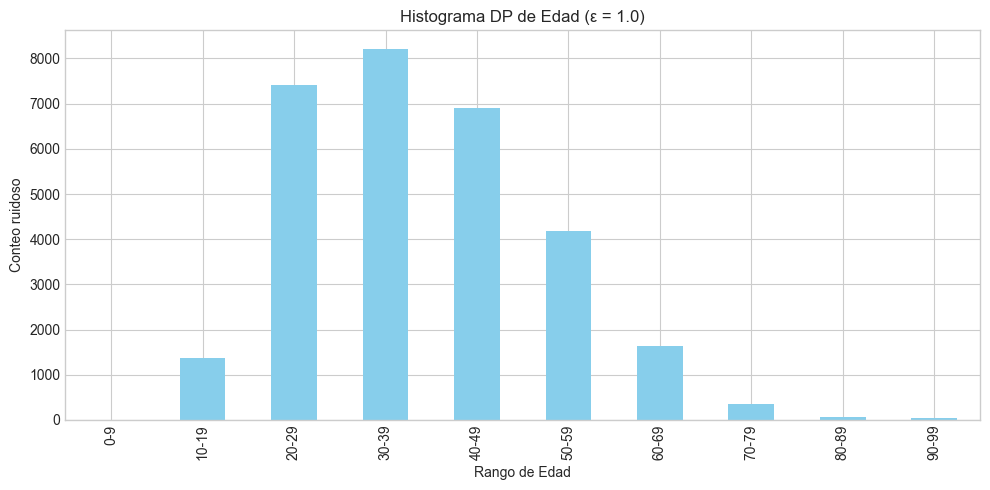

[Series([], Name: count, dtype: float64),
 (9.999, 19.0]    1370.360239
 Name: count, dtype: float64,
 (19.999, 29.0]    7416.014056
 Name: count, dtype: float64,
 (29.999, 39.0]    8210.847056
 Name: count, dtype: float64,
 (39.999, 49.0]    6903.846522
 Name: count, dtype: float64,
 (49.999, 59.0]    4185.127983
 Name: count, dtype: float64,
 (59.999, 69.0]    1635.945962
 Name: count, dtype: float64,
 (69.999, 79.0]    355.351059
 Name: count, dtype: float64,
 (79.999, 89.0]    58.039543
 Name: count, dtype: float64,
 (89.999, 99.0]    34.812731
 Name: count, dtype: float64]

In [70]:
def dp_age_hist(epsilon):
    #si fuera composición secuencial (conjuntos no disjuntos de a pares) entonces 
    #el epsilon sería epsilon/10 para cada bin. Pero como cada bin es disjunto de otro
    #entonces no importa que el epsilon de cada bin sea igual al presupuesto total de 
    #privacidad (y por ende sin violar la privacidad total del sistema).  
    epsilon_bin = epsilon
    #la sensibilidad es 1 porque si agregamos una persona a un bin, el conteo 
    #cambia a lo más en uno.
    sensibilidad = 1
    
    bins = [(10*i, 10*i + 9) for i in range(10)]
    conteos_ruidosos = []
    for i in range(10):
        bins = [int(10*i),10 * i + 9]
        conteo = adult['Age'].value_counts(bins = bins)
        conteo_ruidoso_bin = conteo + np.random.laplace(loc=0.0, scale = sensibilidad / epsilon_bin)
        conteos_ruidosos.append(conteo_ruidoso_bin)
        
    etiquetas = [f"{10*i}-{10*i + 9}" for i in range(10)]
    
    valores = [c.values[0] if not c.empty else 0 for c in conteos_ruidosos]

    df_hist = pd.Series(valores, index=etiquetas)
    df_hist.plot(kind='bar', color='skyblue', figsize=(10,5), 
                 title=f"Histograma DP de Edad (ε = {epsilon})")
    plt.xlabel("Rango de Edad")
    plt.ylabel("Conteo ruidoso")
    plt.tight_layout()
    plt.show()

    return conteos_ruidosos



dp_age_hist(1.0)

- Argue why your definition of `dp_age_hist` is `epsilon`-differential private
- If we change the resulting negative values to zero, does the post-processed result still satisfy `epsilon`-differential private?

- ANSWER 1: Como se dijo en la definición de la función, es diferencialmente privada porque por composición paralela, dado que los bins son conjuntos disjuntos, podemos decir que el costo total de privacidad no será la suma de las privacidades sino el máximo de todas ellas. Pero como nos conviene usar todo el presupuesto para cada bin, simplemente asumimos el máximo (no una fracción de epsilon) sino todo epsilon. Por lo tanto es epsilon-diferencialmente privada.

- ANSWER 2: Si cambiamos los valores resultantes negativos a cero, entonces esto podría afectar a la precisión de los resultados, ya que los valores negativos son parte del ruido Laplaciano. El resultado post-procesamiento seguirá siendo epsilon diferencialmente privado porque por el teorema de post-procesamiento sabemos que si un algoritmo o función cumple con la privacidad diferencial, entonces cualquier postprocesamiento de los resultados también mantendrá la privacidad diferencial, ya sea que se cambien valores negativos por ceros o cualquier otro proceso. 